In [1]:
from datasets import Dataset
import json
import pandas as pd
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import wandb
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from datasets import Dataset
import numpy as np
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

import pandas as pd,os
import torch
from statistics import mode
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer
from datasets import Dataset, load_metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pickle

c:\Users\Ghiki\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess_function(examples, **fn_kwargs):
    return fn_kwargs['tokenizer'](examples["text"], truncation=True)
def get_data(train_path, test_path, random_seed):
    """
    function to read dataframe with columns
    """

    train_df = pd.read_json(train_path, lines=True)
    test_df = pd.read_json(test_path, lines=True)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=random_seed)

    return train_df, val_df, test_df
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm.tolist()
    }
def fine_tune(train_df, valid_df, checkpoints_path, id2label, label2id, model):

    # pandas dataframe to huggingface Dataset
    train_dataset = Dataset.from_pandas(train_df)
    valid_dataset = Dataset.from_pandas(valid_df)
    
    # get tokenizer and model from huggingface
    tokenizer = AutoTokenizer.from_pretrained(model)     # put your model here
    model = AutoModelForSequenceClassification.from_pretrained(
       model, num_labels=len(label2id), id2label=id2label, label2id=label2id    # put your model here
    )
    
    # tokenize data for train/valid
    tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, fn_kwargs={'tokenizer': tokenizer})
    tokenized_valid_dataset = valid_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


    # create Trainer 
    training_args = TrainingArguments(
        output_dir=checkpoints_path,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_valid_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # save best model
    best_model_path = checkpoints_path+'/best/'
    
    if not os.path.exists(best_model_path):
        os.makedirs(best_model_path)
    

    trainer.save_model(best_model_path)
def test(test_df, model_path, id2label, label2id):
    
    # load tokenizer from saved model 
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # load best model
    model = AutoModelForSequenceClassification.from_pretrained(
       model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
    )
            
    test_dataset = Dataset.from_pandas(test_df)

    tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # create Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    # get logits from predictions and evaluate results using classification report
    predictions = trainer.predict(tokenized_test_dataset)
    prob_pred = softmax(predictions.predictions, axis=-1)
    preds = np.argmax(predictions.predictions, axis=-1)
    metric = evaluate.load("bstrai/classification_report")
    results = metric.compute(predictions=preds, references=predictions.label_ids)
    
    # return dictionary of classification report
    return results, preds

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 5/15 [00:01<00:02,  4.10it/s]Trainer is attempting to log a value of "[[8, 3], [5, 4]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                              
 33%|███▎      | 5/15 [00:01<00:02,  4.10it/s]

{'eval_loss': 0.7008172869682312, 'eval_accuracy': 0.6, 'eval_f1': 0.5, 'eval_auc': 0.5858585858585859, 'eval_precision': 0.5714285714285714, 'eval_recall': 0.4444444444444444, 'eval_confusion_matrix': [[8, 3], [5, 4]], 'eval_runtime': 0.1073, 'eval_samples_per_second': 186.375, 'eval_steps_per_second': 18.637, 'epoch': 1.0}


 67%|██████▋   | 10/15 [00:03<00:01,  3.22it/s]Trainer is attempting to log a value of "[[9, 2], [8, 1]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                               
 67%|██████▋   | 10/15 [00:03<00:01,  3.22it/s]

{'eval_loss': 0.6860108375549316, 'eval_accuracy': 0.5, 'eval_f1': 0.16666666666666666, 'eval_auc': 0.46464646464646464, 'eval_precision': 0.3333333333333333, 'eval_recall': 0.1111111111111111, 'eval_confusion_matrix': [[9, 2], [8, 1]], 'eval_runtime': 0.1061, 'eval_samples_per_second': 188.581, 'eval_steps_per_second': 18.858, 'epoch': 2.0}


100%|██████████| 15/15 [00:05<00:00,  3.13it/s]Trainer is attempting to log a value of "[[9, 2], [8, 1]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                               
100%|██████████| 15/15 [00:05<00:00,  3.13it/s]

{'eval_loss': 0.6884660124778748, 'eval_accuracy': 0.5, 'eval_f1': 0.16666666666666666, 'eval_auc': 0.46464646464646464, 'eval_precision': 0.3333333333333333, 'eval_recall': 0.1111111111111111, 'eval_confusion_matrix': [[9, 2], [8, 1]], 'eval_runtime': 0.1065, 'eval_samples_per_second': 187.872, 'eval_steps_per_second': 18.787, 'epoch': 3.0}


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


{'train_runtime': 7.1917, 'train_samples_per_second': 33.372, 'train_steps_per_second': 2.086, 'train_loss': 0.6712141036987305, 'epoch': 3.0}


Map: 100%|██████████| 4000/4000 [00:01<00:00, 3228.84 examples/s]
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 500/500 [00:20<00:00, 24.33it/s]




****** 100 - 0.3344434824928323 ******




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 10/30 [00:02<00:04,  4.38it/s]Trainer is attempting to log a value of "[[4, 14], [3, 19]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                               
 33%|███▎      | 10/30 [00:02<00:04,  4.38it/s]

{'eval_loss': 0.6603240370750427, 'eval_accuracy': 0.575, 'eval_f1': 0.6909090909090909, 'eval_auc': 0.5429292929292929, 'eval_precision': 0.5757575757575758, 'eval_recall': 0.8636363636363636, 'eval_confusion_matrix': [[4, 14], [3, 19]], 'eval_runtime': 0.2062, 'eval_samples_per_second': 194.012, 'eval_steps_per_second': 14.551, 'epoch': 1.0}


 67%|██████▋   | 20/30 [00:06<00:02,  4.15it/s]Trainer is attempting to log a value of "[[2, 16], [2, 20]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                               
 67%|██████▋   | 20/30 [00:06<00:02,  4.15it/s]

{'eval_loss': 0.6857345700263977, 'eval_accuracy': 0.55, 'eval_f1': 0.6896551724137931, 'eval_auc': 0.51010101010101, 'eval_precision': 0.5555555555555556, 'eval_recall': 0.9090909090909091, 'eval_confusion_matrix': [[2, 16], [2, 20]], 'eval_runtime': 0.206, 'eval_samples_per_second': 194.15, 'eval_steps_per_second': 14.561, 'epoch': 2.0}


100%|██████████| 30/30 [00:10<00:00,  4.09it/s]Trainer is attempting to log a value of "[[4, 14], [2, 20]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                               
100%|██████████| 30/30 [00:10<00:00,  4.09it/s]

{'eval_loss': 0.6565167307853699, 'eval_accuracy': 0.6, 'eval_f1': 0.7142857142857143, 'eval_auc': 0.5656565656565656, 'eval_precision': 0.5882352941176471, 'eval_recall': 0.9090909090909091, 'eval_confusion_matrix': [[4, 14], [2, 20]], 'eval_runtime': 0.2069, 'eval_samples_per_second': 193.308, 'eval_steps_per_second': 14.498, 'epoch': 3.0}


100%|██████████| 30/30 [00:11<00:00,  2.53it/s]


{'train_runtime': 11.8755, 'train_samples_per_second': 40.419, 'train_steps_per_second': 2.526, 'train_loss': 0.633319600423177, 'epoch': 3.0}


Map: 100%|██████████| 4000/4000 [00:01<00:00, 3084.59 examples/s]
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 500/500 [00:20<00:00, 24.21it/s]




****** 200 - 0.363069247743454 ******




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 15/45 [00:03<00:06,  4.46it/s]Trainer is attempting to log a value of "[[17, 12], [6, 25]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.

 33%|███▎      | 15/45 [00:03<00:06,  4.46it/s]

{'eval_loss': 0.6516216397285461, 'eval_accuracy': 0.7, 'eval_f1': 0.7352941176470588, 'eval_auc': 0.696329254727475, 'eval_precision': 0.6756756756756757, 'eval_recall': 0.8064516129032258, 'eval_confusion_matrix': [[17, 12], [6, 25]], 'eval_runtime': 0.3199, 'eval_samples_per_second': 187.55, 'eval_steps_per_second': 12.503, 'epoch': 1.0}


 67%|██████▋   | 30/45 [00:08<00:03,  4.40it/s]Trainer is attempting to log a value of "[[23, 6], [13, 18]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.

 67%|██████▋   | 30/45 [00:08<00:03,  4.40it/s]

{'eval_loss': 0.6173883080482483, 'eval_accuracy': 0.6833333333333333, 'eval_f1': 0.6545454545454547, 'eval_auc': 0.6868743047830923, 'eval_precision': 0.75, 'eval_recall': 0.5806451612903226, 'eval_confusion_matrix': [[23, 6], [13, 18]], 'eval_runtime': 0.3061, 'eval_samples_per_second': 196.044, 'eval_steps_per_second': 13.07, 'epoch': 2.0}


100%|██████████| 45/45 [00:12<00:00,  4.41it/s]Trainer is attempting to log a value of "[[19, 10], [8, 23]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.

100%|██████████| 45/45 [00:13<00:00,  4.41it/s]

{'eval_loss': 0.611975908279419, 'eval_accuracy': 0.7, 'eval_f1': 0.71875, 'eval_auc': 0.6985539488320356, 'eval_precision': 0.696969696969697, 'eval_recall': 0.7419354838709677, 'eval_confusion_matrix': [[19, 10], [8, 23]], 'eval_runtime': 0.3057, 'eval_samples_per_second': 196.256, 'eval_steps_per_second': 13.084, 'epoch': 3.0}


100%|██████████| 45/45 [00:14<00:00,  3.09it/s]


{'train_runtime': 14.549, 'train_samples_per_second': 49.488, 'train_steps_per_second': 3.093, 'train_loss': 0.6333093855116102, 'epoch': 3.0}


Map: 100%|██████████| 4000/4000 [00:01<00:00, 2922.83 examples/s]
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 500/500 [00:20<00:00, 24.45it/s]




****** 300 - 0.34927575441021086 ******




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 33%|███▎      | 20/60 [00:04<00:08,  4.48it/s]Trainer is attempting to log a value of "[[16, 22], [5, 37]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                               
 33%|███▎      | 20/60 [00:05<00:08,  4.48it/s]

{'eval_loss': 0.6400076150894165, 'eval_accuracy': 0.6625, 'eval_f1': 0.7326732673267327, 'eval_auc': 0.6510025062656641, 'eval_precision': 0.6271186440677966, 'eval_recall': 0.8809523809523809, 'eval_confusion_matrix': [[16, 22], [5, 37]], 'eval_runtime': 0.4107, 'eval_samples_per_second': 194.789, 'eval_steps_per_second': 12.174, 'epoch': 1.0}


 67%|██████▋   | 40/60 [00:10<00:04,  4.44it/s]Trainer is attempting to log a value of "[[17, 21], [5, 37]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                               
 67%|██████▋   | 40/60 [00:11<00:04,  4.44it/s]

{'eval_loss': 0.6154470443725586, 'eval_accuracy': 0.675, 'eval_f1': 0.7400000000000001, 'eval_auc': 0.6641604010025062, 'eval_precision': 0.6379310344827587, 'eval_recall': 0.8809523809523809, 'eval_confusion_matrix': [[17, 21], [5, 37]], 'eval_runtime': 0.4163, 'eval_samples_per_second': 192.188, 'eval_steps_per_second': 12.012, 'epoch': 2.0}


100%|██████████| 60/60 [00:16<00:00,  4.47it/s]Trainer is attempting to log a value of "[[22, 16], [8, 34]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                               
100%|██████████| 60/60 [00:17<00:00,  4.47it/s]

{'eval_loss': 0.5951750874519348, 'eval_accuracy': 0.7, 'eval_f1': 0.7391304347826089, 'eval_auc': 0.6942355889724311, 'eval_precision': 0.68, 'eval_recall': 0.8095238095238095, 'eval_confusion_matrix': [[22, 16], [8, 34]], 'eval_runtime': 0.4072, 'eval_samples_per_second': 196.463, 'eval_steps_per_second': 12.279, 'epoch': 3.0}


100%|██████████| 60/60 [00:18<00:00,  3.28it/s]


{'train_runtime': 18.2993, 'train_samples_per_second': 52.461, 'train_steps_per_second': 3.279, 'train_loss': 0.6342798233032226, 'epoch': 3.0}


Map: 100%|██████████| 4000/4000 [00:01<00:00, 2955.90 examples/s]
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 500/500 [00:20<00:00, 24.59it/s]




****** 400 - 0.5170642928932201 ******


100 - 0.3344434824928323
200 - 0.363069247743454
300 - 0.34927575441021086
400 - 0.5170642928932201


ValueError: x and y must have same first dimension, but have shapes (1,) and (4,)

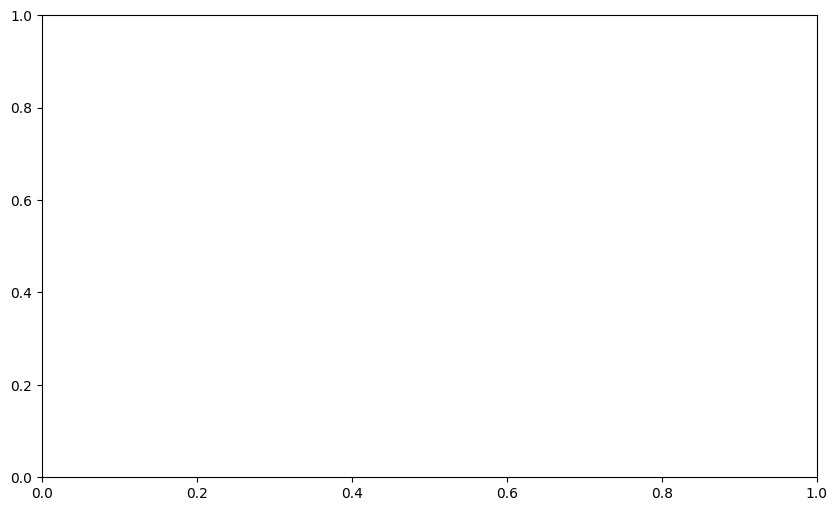

In [4]:
random_seed = 0

model = 'bert-base-uncased'

samples=[500,1000,2000,4000,6000,8000]
f1_scores = []

for SAMPLES_TO_TRAIN in samples:

    df= pd.read_json('datasets/subtaskA_train_multilingual.jsonl', lines=True)

    # df = df.rename(columns={'source': 'language'})
    # non_language_sources = ['wikihow', 'wikipedia', 'reddit', 'arxiv', 'peerread']
    # df['language'] = df['language'].replace(non_language_sources, 'english')
    # rus = RandomUnderSampler(random_state=42)
    # X_resampled, y_resampled = rus.fit_resample(df.drop('language', axis=1), df['language'])
    # df = pd.concat([X_resampled, y_resampled], axis=1)

    df=df.sample(SAMPLES_TO_TRAIN)

    df.to_json('reducedTrainDataFrame.jsonl', orient='records', lines=True)

    train_path =  'reducedTrainDataFrame.jsonl'
    test_path =  'datasets/subtaskA_dev_multilingual.jsonl'

    subtask =  'A'
    prediction_path = 'reducedPredictedDataFrame.jsonl'

    if not os.path.exists(train_path):
        logging.error("File doesnt exists: {}".format(train_path))
        raise ValueError("File doesnt exists: {}".format(train_path))

    if not os.path.exists(test_path):
        logging.error("File doesnt exists: {}".format(train_path))
        raise ValueError("File doesnt exists: {}".format(train_path))

    if subtask == 'A':
        id2label = {0: "human", 1: "machine"}
        label2id = {"human": 0, "machine": 1}
    elif subtask == 'B':
        id2label = {0: 'human', 1: 'chatGPT', 2: 'cohere', 3: 'davinci', 4: 'bloomz', 5: 'dolly'}
        label2id = {'human': 0, 'chatGPT': 1,'cohere': 2, 'davinci': 3, 'bloomz': 4, 'dolly': 5}
    else:
        logging.error("Wrong subtask: {}. It should be A or B".format(train_path))
        raise ValueError("Wrong subtask: {}. It should be A or B".format(train_path))

    set_seed(random_seed)

    train_df, valid_df, test_df = get_data(train_path, test_path, random_seed)

    fine_tune(train_df, valid_df, f"testing_models/{model.split('/')[-1]}_{SAMPLES_TO_TRAIN}", id2label, label2id, model)

    results, predictions = test(test_df, f"testing_models/{model.split('/')[-1]}_{SAMPLES_TO_TRAIN}/best/", id2label, label2id)

    f1_score=results['macro avg']['f1-score']

    with open(f"testing_models/{model.split('/')[-1]}_{SAMPLES_TO_TRAIN}/best/f1_score.json", 'w') as file:
        json.dump({'f1_score': f1_score}, file)
    
    f1_scores.append(f1_score)
        
    print(f'\n\n****** {SAMPLES_TO_TRAIN} - {f1_score} ******\n\n')

from IPython.display import clear_output
clear_output(wait=True)

for SAMPLES_TO_TRAIN,f1_score in zip(samples,f1_scores):
    print(f'{SAMPLES_TO_TRAIN} - {f1_score}')

import matplotlib.pyplot as plt
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(samples, f1_scores, marker='o', linestyle='-')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score (Macro Avg)')
plt.title('F1 Score vs Number of Training Samples')
plt.grid(True)
plt.savefig(f"testing_models/{model.split('/')[-1]}_{SAMPLES_TO_TRAIN}_f1_scores.png")
plt.show()